In [71]:

cd drive/MyDrive/Colab\ Notebooks/


[Errno 2] No such file or directory: 'drive/MyDrive/Colab Notebooks/'
/content/drive/MyDrive/Colab Notebooks


In [72]:
ls

 CMPUT466_Coding_Assignment1_Thasanka_Kandage_1716597.ipynb
 CMPUT466_CodingAssignment2_ThasankaKandage_1716597.ipynb
 csv_temp_profiles/
 database.db
 dataset_A_linear.png
 dataset_A_logistic.png
 dataset_B_linear.png
 dataset_B_logistic.png
'ECE 449 Lab 1 - Thasanka Kandage 1716597.ipynb'
'ECE449_Lab2_Thasanka Kandage 1716597.ipynb'
 ECE449_Lab3_Thasanka_Kandage_1716597
 ECE449_Lab4_Thasanka_Kandage_17165971.ipynb
 ECE449_Lab5_An_Huynh.ipynb
 ECE449_Lab5_ThasankaKandage_1716597.ipynb
 Forecasting.ipynb
 Learning_PyTorch.ipynb
 ML_Models_TempProfiles.ipynb
 paper_plots_and_im_crossover.ipynb
'PG PI ML_Models_TempProfiles.ipynb'
 PhysicsGuidedNN_Modeling_VTDP.ipynb
 t10k-images-idx3-ubyte.idx3-ubyte
 t10k-labels-idx1-ubyte.idx1-ubyte
 Theoretical_VTDP/
 thermal_model_weights.pth
 tipper_test.csv
 tipper_train.csv
 train-images-idx3-ubyte.idx3-ubyte
 train-labels-idx1-ubyte.idx1-ubyte
 Trimmed_TC_updated/
 Untitled0.ipynb
 Untitled1.ipynb
 Untitled2.ipynb
 Untitled3.ipynb
 Untitled4.ipy

# Imports + Setup

In [73]:
import os, re
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [74]:
# Set seeds for reproducibility
import random
SEED = 1
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior for CUDA
torch.backends.cudnn.benchmark = False      # Disable auto-tuner that can introduce randomness

In [75]:
# File Mapping
h_map = {2: 0.0375, 3: 0.084, 6: 0.1575}
flux_map = {88: 25900, 78: 21250, 73: 19400}
abs_map = {0: 3, 92: 100}
surf_map = {0: 0.98, 1: 0.76}
pattern = r"h(\d+)_flux(\d+)_abs(\d+)(?:_[A-Za-z0-9]+)*_surf([01])(?:_[A-Za-z0-9]+)*[\s_]+(\d+)s\b"
# Depending on where u store the data files
# cd drive/MyDrive/Colab\ Notebooks/Theoretical_VTDP
# DATA_DIR = "../../data/Theoretical_VTDP"
DATA_DIR = "Theoretical_VTDP/"
DROP_COLS = ["TC_9_5", "TC_Bottom_rec_groove", "TC_wall_ins_ext", "TC_bottom_ins_groove", "Theoretical_Temps_11"]

# Utilities

In [76]:
def parse_filename_params(filename):
    m = re.search(pattern, filename)
    if not m:
        return None
    h_raw    = int(m.group(1))
    flux_raw = int(m.group(2))
    abs_raw  = int(m.group(3))
    surf_raw = int(m.group(4))
    t        = int(m.group(5))

    # keeping number if no entry exists
    h    = h_map.get(h_raw,    h_raw)
    flux = flux_map.get(flux_raw, flux_raw)
    abs_ = abs_map.get(abs_raw,  abs_raw)
    surf = surf_map.get(surf_raw)

    return h, flux, abs_, surf, t

def load_and_process_file(path, h, flux, abs_val, surf, min_time):
    df = pd.read_csv(path, encoding="utf-8-sig")
    df = df[df["Time"] >= min_time].copy()
    df.drop(columns=[col for col in df.columns if col in DROP_COLS or col.startswith("Depth_")], inplace=True)
    df["h"] = h
    df["flux"] = flux
    df["abs"] = abs_val
    df["surf"] = surf
    return df

# Load and Combine Data

In [77]:
dataframes = []
for fname in os.listdir(DATA_DIR):
    if not fname.endswith(".csv"):
        continue
    params = parse_filename_params(fname)
    if params is None or params[3] is None:
        print("Skipping:", fname)
        continue
    path = os.path.join(DATA_DIR, fname)
    df = load_and_process_file(path, *params)
    dataframes.append(df)

data = pd.concat(dataframes, ignore_index=True)
print(data.info())
print(data.head())


Skipping: h2_flux88_abs25_wr_surfSimD_525s - Sheet1_processed.csv
Skipping: h2_flux88_abs25_wr_surfParAdded_169s - Sheet1_processed.csv
Skipping: PG_combined_data.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66146 entries, 0 to 66145
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Time                  66146 non-null  int64  
 1   TC1_tip               66146 non-null  float64
 2   TC2                   66146 non-null  float64
 3   TC3                   66146 non-null  float64
 4   TC4                   66146 non-null  float64
 5   TC5                   66146 non-null  float64
 6   TC6                   66146 non-null  float64
 7   TC7                   66146 non-null  float64
 8   TC8                   66146 non-null  float64
 9   TC9                   66146 non-null  float64
 10  TC10                  66146 non-null  float64
 11  Theoretical_Temps_1   66146 non-null  float64
 12  Theor

# Preprocessing

In [78]:
theory_cols = [c for c in data.columns if c.startswith("Theoretical_Temps_")]
X = data[["Time", "h", "flux", "abs", "surf"] + theory_cols]
y = data.drop(columns=["Time", "h", "flux", "abs", "surf"] + theory_cols)
y_columns = y.columns

X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
X_scaled = X_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)

X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=SEED) # 70% of dataset is training
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=SEED) # 15% of entire dataset is val and another 15 is test

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Model

In [79]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        return self.fc4(x)

input_size = X_train.shape[1]
output_size = y_train.shape[1]
model = NeuralNet(input_size, output_size)

# Training

In [80]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 500

train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train)
    train_loss = criterion(predictions, y_train)
    train_loss.backward()
    optimizer.step()

    # validate
    model.eval()
    with torch.no_grad():
        val_preds = model(X_test)
        val_loss = criterion(val_preds, y_test)

    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())

    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {train_loss.item():.6f}, Val Loss: {val_loss.item():.6f}")

Epoch [50/500], Train Loss: 0.040442, Val Loss: 0.038569
Epoch [100/500], Train Loss: 0.019138, Val Loss: 0.017681
Epoch [150/500], Train Loss: 0.012083, Val Loss: 0.010869
Epoch [200/500], Train Loss: 0.009907, Val Loss: 0.008698
Epoch [250/500], Train Loss: 0.008813, Val Loss: 0.007656
Epoch [300/500], Train Loss: 0.008473, Val Loss: 0.007372
Epoch [350/500], Train Loss: 0.008255, Val Loss: 0.007183
Epoch [400/500], Train Loss: 0.008120, Val Loss: 0.007068
Epoch [450/500], Train Loss: 0.008019, Val Loss: 0.006974
Epoch [500/500], Train Loss: 0.007931, Val Loss: 0.006894


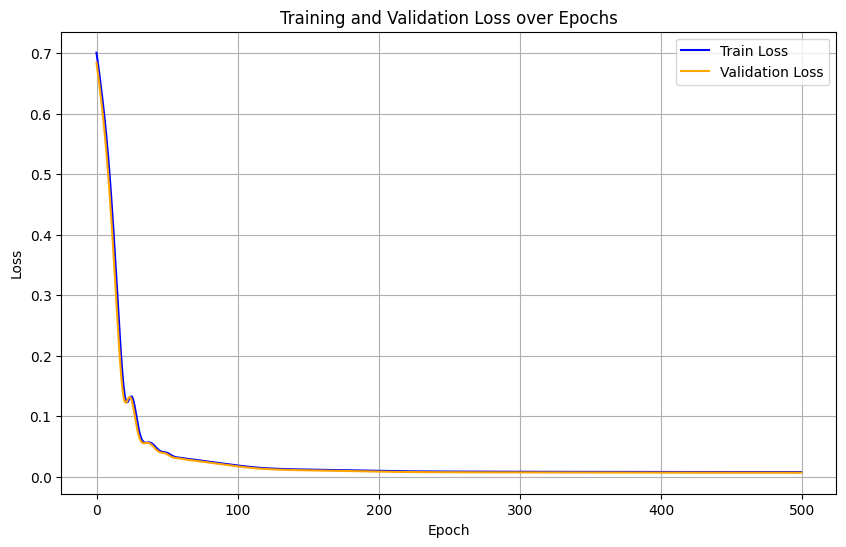

In [81]:
# ✅ Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation

In [82]:
model.eval()
with torch.no_grad():
    preds = model(X_test).numpy()

preds_real = y_scaler.inverse_transform(preds)
y_real = y_scaler.inverse_transform(y_test.numpy())
rmse = np.sqrt(np.mean((preds_real - y_real) ** 2, axis=0))

print("\nRMSE per output (°C):")
for col, val in zip(y.columns, rmse):
    print(f"{col}: {val:.3f} °C")

print(f"\nAverage RMSE across all outputs: {np.mean(rmse):.3f} °C")

torch.save(model.state_dict(), "thermal_model_weights.pth")
print("Model weights saved to 'thermal_model_weights.pth'")


RMSE per output (°C):
TC1_tip: 30.109 °C
TC2: 29.717 °C
TC3: 30.204 °C
TC4: 29.780 °C
TC5: 29.725 °C
TC6: 29.556 °C
TC7: 29.955 °C
TC8: 30.677 °C
TC9: 32.297 °C
TC10: 35.238 °C

Average RMSE across all outputs: 30.726 °C
Model weights saved to 'thermal_model_weights.pth'


<!-- ----------------------------------------------------------------------------------------------------------------------------------- -->

In [83]:
new_input = [
    [  # Full input vector for inference
        1049.0,     # Time (seconds)
        0.1575,     # Depth (h)
        25900,      # Heat flux (q0)
        3,          # Absorption coefficient (abs)
        0.98        # Surface emissivity (surf)
    ] + [350.0]*10  # Theoretical temperature values at 10 vertical points
]
new_input_scaled = X_scaler.transform(new_input)
new_tensor = torch.tensor(new_input_scaled, dtype=torch.float32)

with torch.no_grad():
    pred = model(new_tensor).numpy()
real_pred = y_scaler.inverse_transform(pred)
print("\nPredicted Temperatures:", real_pred)



Predicted Temperatures: [[340.06152 337.89517 339.95825 337.16284 340.06653 340.61966 341.27878
  342.48294 340.9035  330.3166 ]]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
